In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random as rd

Vamos utilizar um algoritmo genético pra resolver o famoso problema do vendedor ambulante.

O problema consiste de um vendedor que precisa visitar $N$ cidades (pontos) e voltar para a posição inicial pela rota que minimiza a distância total que ele vai ter que andar. Queremos encontrar essa rota.

# Algoritmo Genético/Evolutivo

O algoritmo consiste em imitar o processo evolutivo que ocorre na natureza para encontrar o genoma mais apto para resolver o problema. Utilizamos três conceitos importantes:

1 - Hereditariedade

2 - Mutação

3 - Seleção

Neste caso cada genoma das nossas "criaturas" representará uma rota possível, e a ordem dos seus genes irá codificar a ordem em que vamos visitar cada ponto. Por exemplo: se tivermos apenas 3 cidades para visitar, o genoma $[c_1,c_2,c_3]$ corresponde a uma rota que começa na $c_1$, passa pela $c_2$, pela $c_3$, e volta pra $c_1$.

Começaremos com uma população de tantas criaturas cujos genomas serão definidos aleatoriamente, aquelas que tiverem melhor sucesso sobreviverão e poderão se reproduzir (isso envolverá um algoritmo de cross over em que um novo genoma será produzido da combinação dos genes dos pais), e as criaturas com pior performance serão substituídas pelas novas e esquecidas na próxima geração. Também incluiremos um mecanismo de mutação, em que (com uma probabilidade que iremos definir) uma criatura terá a ordem dos seus genes alterada aleatoriamente; isso ajuda a garantir diversidade genética e faz com que diferentes possibilidades sejam exploradas pelo algoritmo, impedindo a estagnação.

In [2]:
class genes:
    
    # dados, tamanho da pop
    def __init__(self,x,n_pop):
        # sempre começamos no x[0]
        self.x = x
        self.M = len(x)
        self.dim = len(x[0])
        
        # sobra M-1 pontos pra visitar
        self.points = np.arange(self.M-1)
        pop = np.zeros((n_pop,self.M-1))
        for p in range (n_pop):
            np.random.shuffle(self.points)
            pop[p] = self.points
        # população inicial
        self.pop = pop.astype(int)
    
    
    # retorna pontuação (fit) objetiva da população
    def fit(self,pop):
        x = self.x
        N = len(pop)
        dim = len(pop[0])
        x0 = x[0]
        f = np.zeros((N,1))
        # nesse caso o fit é a dist total (e queremos a menor)
        for p in range (N):
            D = dist(x0,x[pop[p,0]])
            for i in range (dim-1):
                D = D + dist(x[pop[p,i]],x[pop[p,i+1]])
            D = D + dist(x[pop[p,dim-1]],x0)
            f[p] = D
        return f
    
    
    # pontuação relativa (usada como chance de reprodução)
    def bestf(self,pop):
        f = self.fit(pop)
        # função arbitrária pra definir a chance 
        # de reprodução com base no fit
        b = 1 - (f/np.max(f))**2
        return b
    
    
    # produzir nova população
    # população, pontuação relativa, % da pop a nascer, chance de mutação
    def crossover(self,pop,b,sex,mut):
        N = len(pop)
        dim = self.M - 1
        # nª genomas que sobrevivem pra próxima geração
        n_survive = np.int(np.round(N*(1-sex)))
        # nova população
        Pop = np.zeros((N,dim))
        n = 0
        
        # os que sobrevivem
        for i in range(n_survive):
            # i-ésimo melhor apto
            s = (-b).argsort()[i]
            Pop[n] = pop[s]
            n = n + 1
        
        # novos genomas que vão nascer
        while n < N:
            for i in range(N):
                # pra cada genoma checamos a chance de reprodução
                if rd.random() < b[i]:
                    for j in range(N):
                        if rd.random() < b[j] and i != j:
                            # uma vez que dois genomas copulam, suas
                            # chances de copularem de novo cai
                            b[i] = b[i]*3/4
                            b[j] = b[j]*3/4
                            
                            # cruza os genomas e adiciona uma combinação
                            A = cross(pop[i],pop[j])
                            Pop[n] = A[0]
                            n = n + 1
                            
                            # checa se já encheu a população
                            if n == N:
                                break
                            # senão adiciona a outra combinação
                            Pop[n] = A[1]
                            n = n + 1
                            if n == N:
                                break
                if n == N:
                    break
        
        # realiza as mutações
        for p in range(len(Pop)):
            if rd.random() < mut:
                # indice do gene que vai sofrer mut
                ga = np.int(rd.random()*(dim))
                gb = np.int(rd.random()*(dim))
                while gb == ga:
                    gb = np.int(rd.random()*(dim))
                
                # troca os genes de lugar
                Pop[p] = troca(Pop[p],ga,gb)
                    
        return Pop.astype(int)
    
    
    # evolução
    #  % da pop a nascer, chance de mutação, nº max de gerações
    def evoluir(self,sex,mut,ger):
        x = self.x
        pop = self.pop
        N = len(pop)
        
        Bests = np.zeros(ger)
        Bests[0] = np.min(self.fit(pop))
        
        Bop = pop.copy()
        for g in range(1,ger,1):
            # determina a chance de rep de cada um
            b = self.bestf(pop)
            # realiza o sexo e as mutações
            pop = self.crossover(pop,b,sex,mut)
            
            # se houve melhoria nós atualizamos a população
            # (sem esse código é possível que o fit de uma geração fique
            # pior que a anterior por pura chance, tomando muito tempo.
            if np.min(self.fit(pop)) <= np.min(self.fit(Bop)):
                Bop = pop.copy()
                
            Bests[g] = np.min(self.fit(Bop))
        
        # atualiza a população
        self.pop = Bop
        return Bests
    
    
    # retorna o melhor genoma da geração atual, e seu caminho
    def best(self):
        pop = self.pop
        f = self.fit(self.pop)
        # pega o genoma com melhor fit (nesse casso menor dist)
        best = pop[np.argmin(f)]

        y = np.zeros((self.M,self.dim))
        y[0] = x[0]
        for i in range (self.M-1):
            y[i+1] = x[best[i]+1]
            
        # retorna o genoma e sua dist
        return y, np.min(self.fit(pop))


# função pra calcular dist entre 2 pontos
def dist(x1,x2):
    d2 = 0
    if type(x1)==int:
        # pitágoras pra só uma dimensão
        d2 = d2 + (x1-x2)**2
    else:
        # usa pitagoras pra várias dimensões
        for i in range (len(x1)):
            d2 = d2 + (x1[i]-x2[i])**2
    return np.sqrt(d2)


# troca elementos de indice a e b do array A 
def troca(A,a,b):
    A1 = A[a]
    A2 = A[b]
    # é importante usar a função copy aqui ao invés de "="
    # porque senão alterações em B iriam alterar A também
    B = A.copy()
    B[a] = A2
    B[b] = A1
    return B


# troca as metades dos vetores A e B (sem repetir)
# input: A = [1,3,5,7], B = [2,4,6,8]
# output: C = [1,3,6,8], D = [2,4,5,7]
def cross(A,B):
    dim = len(A)
    met_d = np.int(np.round(dim/2))
    
    # lista dos genes
    Pa = A.tolist()
    Pb = B.tolist()
    # metades dos genomas de A
    ga1, ga2 = Pa[:-met_d], Pa[(dim-met_d):]
    gb1, gb2 = [], []
    i = 0
    # pra não retornar com genes repetidos:
    while len(gb1+gb2) != len(Pb):
        if any(flag == Pb[i]  for (flag) in ga1) == True:
            gb1.append(Pb[i])
            i = i + 1
        else:
            if len(gb2) != len(ga2):
                gb2.append(Pb[i])
                i = i + 1
        
        if len(gb1+gb2) == len(Pb):
            break
        
        if any(flag == Pb[i]  for (flag) in ga2) == True:
            gb2.append(Pb[i])
            i = i + 1
        else:
            if len(gb1) != len(ga1):
                gb1.append(Pb[i])
                i = i + 1
        
    C, D = ga1 + gb2, gb1 + ga2
    return np.array(C),np.array(D)


# troca as metades dos vetores A e B (pode repetir)
def crossrep(A,B):
    dim = len(A)
    met_d = np.int(np.round(dim/2))
    
    Pa = A.tolist()
    Pb = B.tolist()
    ga1, ga2 = Pa[:-met_d],Pa[(dim-met_d):]
    gb1, gb2 = Pb[:-met_d],Pb[(dim-met_d):]    
    
    C, D = ga1 + gb2, gb1 + ga2
    return np.array(C), np.array(D)

# Vendedor ambulante

A distribuição das cidades é definida abaixo, sendo o primeiro ponto $(0,0)$ sempre a posição da primeira cidade.

Essa distribuição é tal (se você não alterar os valores) que fica fácil de encontrar a melhor rota no só olhando, ela deverá ser algo meio circular e sem muito zigzague.

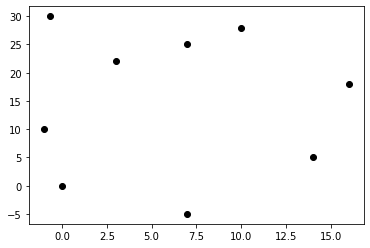

In [3]:
# coordenadas das cidades
x = np.array([[0,0],[7,-5],[14,5],[16,18],[10,28],[7,25],[-0.7,30],[3,22],[-1,10]])

plt.scatter(x[:,0],x[:,1],c='k')

Abaixo geramos uma população inicial com genomas definidos aleatoriamente, então não esperamos encontrar uma rota ideal logo de cara.

Na realidade, dependendo da complexidade do problema (o nª de cidades que temos que visitar) e o tamanho da população inicial, é possivel gerarmos a solução ideal logo de cara por pura chance! Por exemplo, se gerarmos um milhão de genomas diferentes é bem provável que uma boa parcela deles acabe sendo exatamente a resposta que procuramos. Isso é um fato estatístico, mas pode nao ser uma estratégia muito eficiente para problemas mais complicados.

Distância = 119.48504191965253


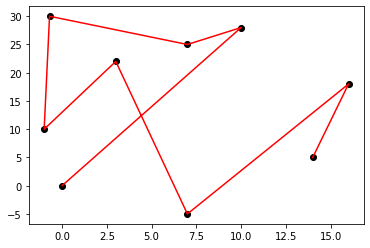

In [4]:
# Tamanho da população
n_pop = 20
viagem = genes(x,n_pop)

# devolve o melhor genoma inicial
best = viagem.best()
z = best[0] 
Z = best[1]

print('Distância =', Z)
plt.plot(z[:,0],z[:,1],c='r')
plt.scatter(x[:,0],x[:,1],c='k')

Distância final = 90.0651267641141


Text(0, 0.5, 'Distância')

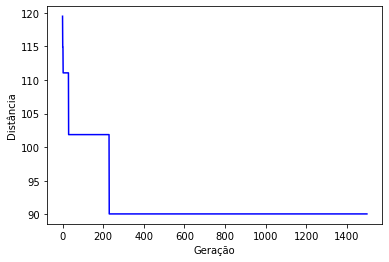

In [5]:
# Realiza a evolução
# (% da pop que nasce, chance de mutação, nº max de gerações)
evol = viagem.evoluir(0.25,0.4,1500)

print('Distância final =', evol[-1])
plt.plot(evol,c='b')
plt.xlabel('Geração')
plt.ylabel('Distância')


Distância inicial = 119.48504191965253 

Distância final = 90.0651267641141


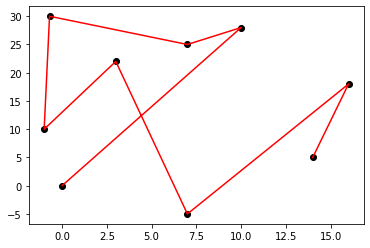

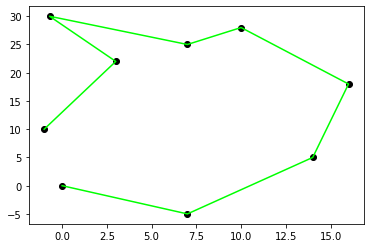

In [6]:
# pega o melhor depois da evolução
best = viagem.best()
y = best[0]
Y = best[1]
print('\nDistância inicial =', Z, '\n\nDistância final =', Y)


# plotamos pra comparar o antes e o depois
plt.subplot(1,1,1)
plt.plot(z[:,0],z[:,1],c='r')
plt.scatter(x[:,0],x[:,1],c='k')
plt.show()

plt.subplot(1,1,1)
plt.plot(y[:,0],y[:,1],c='lime')
plt.scatter(x[:,0],x[:,1],c='k')
plt.show()